In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, plot_results


import sys
sys.path.append(base_dir+'train/kerastuner_hpsearch/utils/')
from train_utils import create_ann, scheduler

import sys
sys.path.append(base_dir+'train/kerastuner_hpsearch/hp_results/')
from tfexp_hp import get_hp

2025-01-17 09:53:30.571181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 09:53:30.642932: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


### Load standardized E3SM

In [3]:
EXP_NAME_DATA = 'exp_data'
hps_data = get_hp(EXP_NAME_DATA)
print('Training Members: '+str(hps_data['train_mems']))
print('Validation Member: '+str(hps_data['val_mems'][0]))
print('Testing Member: '+str(hps_data['test_mems'][0]))
print('Lead: '+str(hps_data['LEAD']))
print('Region: '+str(hps_data['region'][0])+'N x '+str(hps_data['region'][1])+'E')

Xtrain, Xval, _, Ytrain, Yval, _, _ = split_SDbias(trainmems = hps_data['train_mems'],
                                                      valmem = hps_data['val_mems'][0],
                                                      testmem = hps_data['test_mems'][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps_data['LEAD']) # 330 or 210

Xval = Xval.reshape((Xval.shape[0],Xval.shape[1]*Xval.shape[2]))
Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]))
input_shape = Xtrain.shape[1]

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
files do not exist - loading data & saving


### Train NN

In [4]:
# ---------- ANN Hyperparameters ----------
EXP_NAME = 'exp_2.BO'
hps_kt = get_hp(EXP_NAME)

NLABEL = 2
N_EPOCHS = 1000
dropout = True
PATIENCE = hps_kt['PATIENCE']
GLOBAL_SEED = hps_kt['GLOBAL_SEED']

HIDDENS = hps_kt['HIDDENS']
BATCH_SIZES = hps_kt['BATCH_SIZES']
LR_INITS = hps_kt['LR_INITS']
DROPOUT_RATES = hps_kt['DROPOUT_RATES']
# RIDGES = hps_kt['RIDGES']

In [5]:
def kt_train(hp):
    tf.keras.backend.clear_session() 

    # ----- input of ann -----
    ann_input = tf.keras.Input(shape=input_shape)

    # Number of layers (either 1 or 2)
    num_layers = hp.Choice('num_layers', values=[1, 2])

    # ----- ann layers -----
    x = tf.keras.layers.Dense(units=hp.Choice('units1',values=HIDDENS),
                              activation='relu',
                              use_bias=True, 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0,l2=0.0),
                              bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                              kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)
                              )(ann_input)
    if dropout:
        x = tf.keras.layers.Dropout(rate=hp.Choice('dropout',values=DROPOUT_RATES))(x)
    
    if num_layers == 2:
        x = tf.keras.layers.Dense(units=hp.Choice('units2',values=HIDDENS),
                                  activation='relu',
                                  use_bias=True,
                                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)
                                  )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(NLABEL,
                                       activation=tf.keras.activations.softmax,
                                       use_bias=True,
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = tf.keras.Model(ann_input, ann_output, name = 'ann')


    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=LR_INITS),)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)

    return ann

Trial 90 Complete [00h 00m 23s]
val_loss: 0.659733772277832

Best val_loss So Far: 0.6586111783981323
Total elapsed time: 00h 37m 24s
Elapsed time during fit = 2244.07 seconds

Best Trial ID: 22
Number of Layers: 1
First Layer: 256
Learning Rate: 0.0001
Dropout: 0.9
Batch Size: 1028


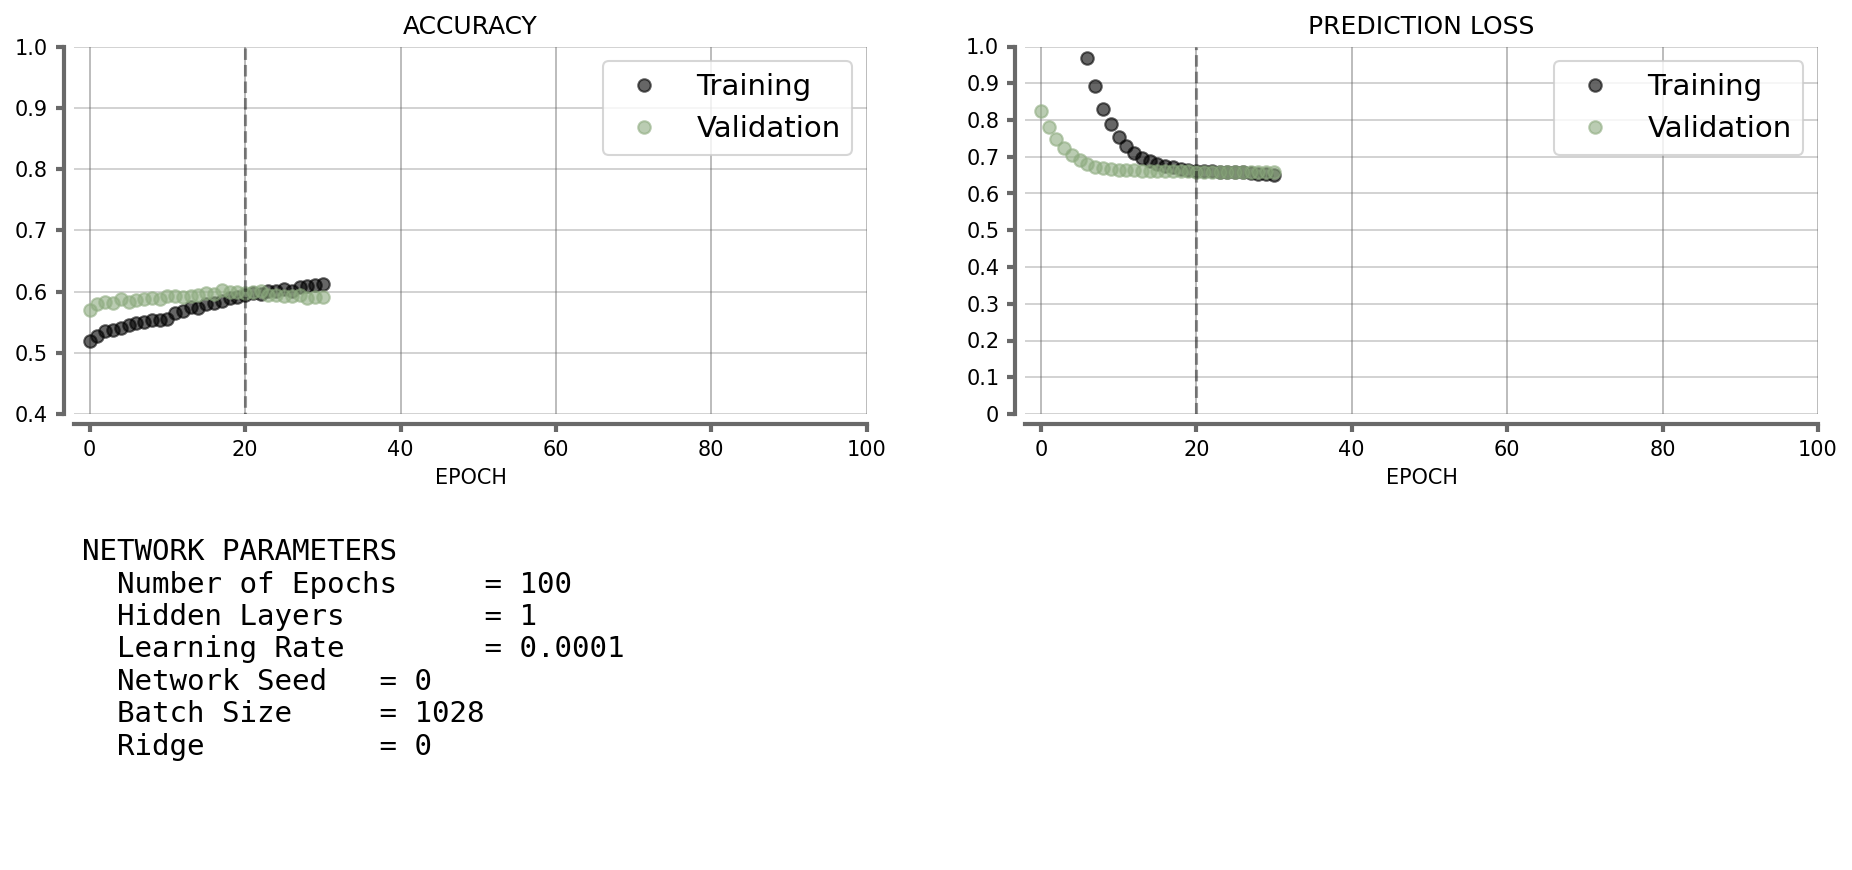

Best Trial ID: 24
Number of Layers: 2
First Layer: 256
Second Layer: 16
Learning Rate: 0.0001
Dropout: 0.9
Batch Size: 1028


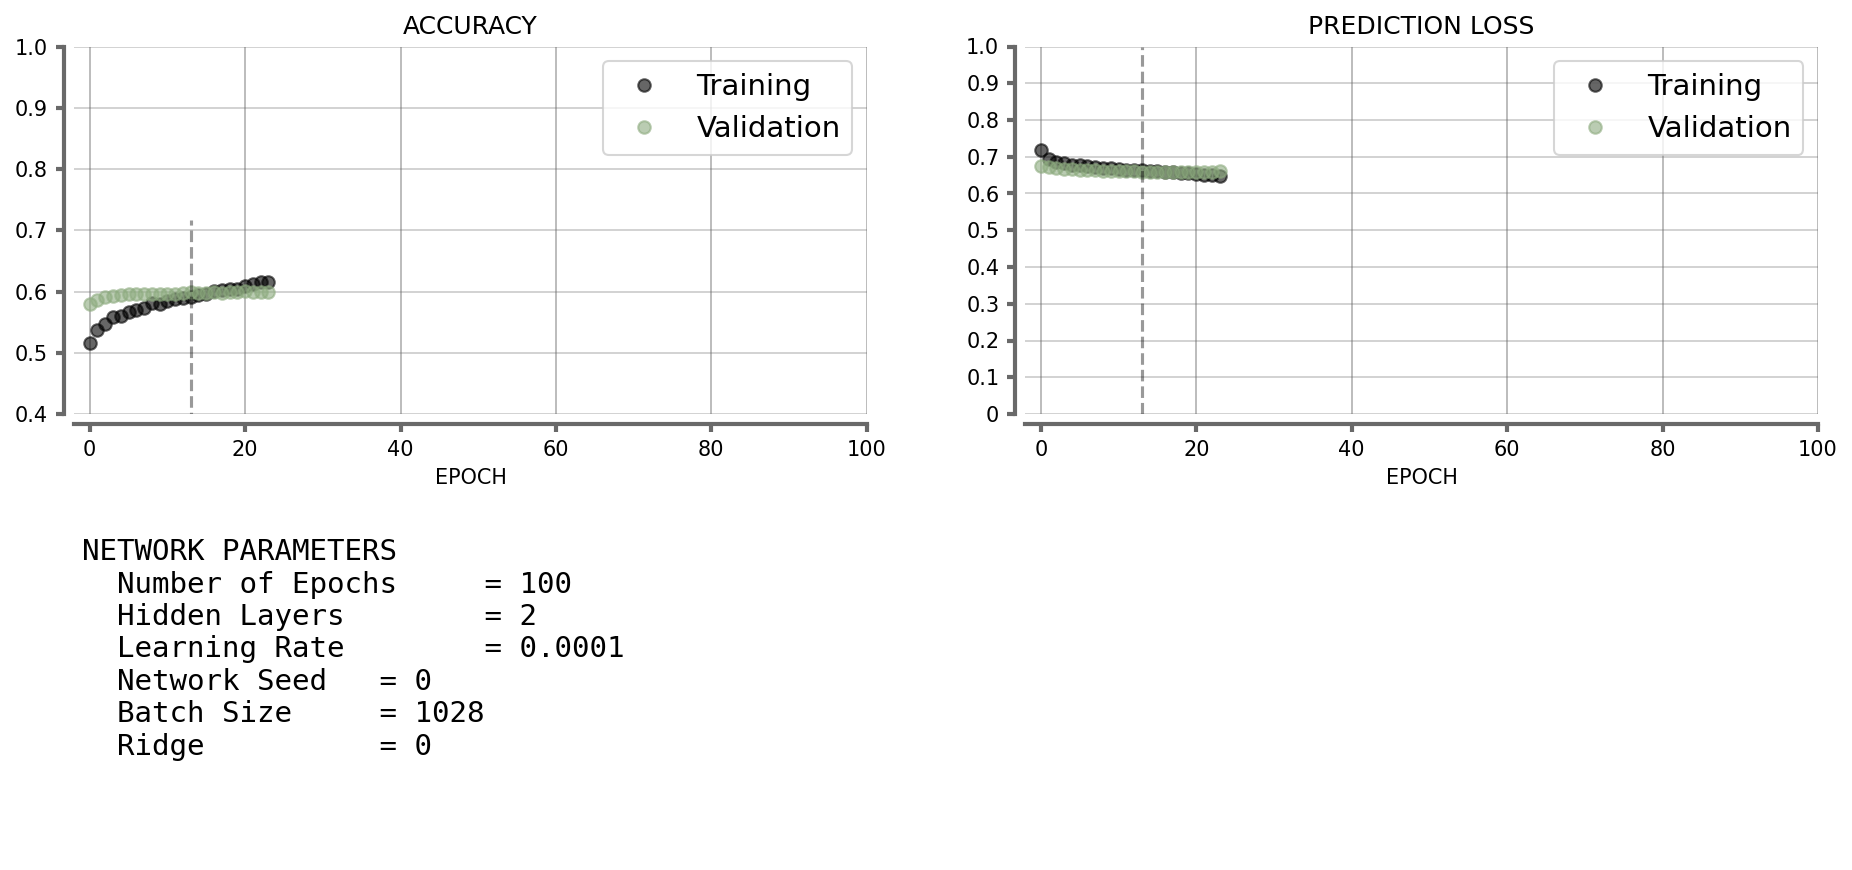

Best Trial ID: 13
Number of Layers: 1
First Layer: 128
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 1028


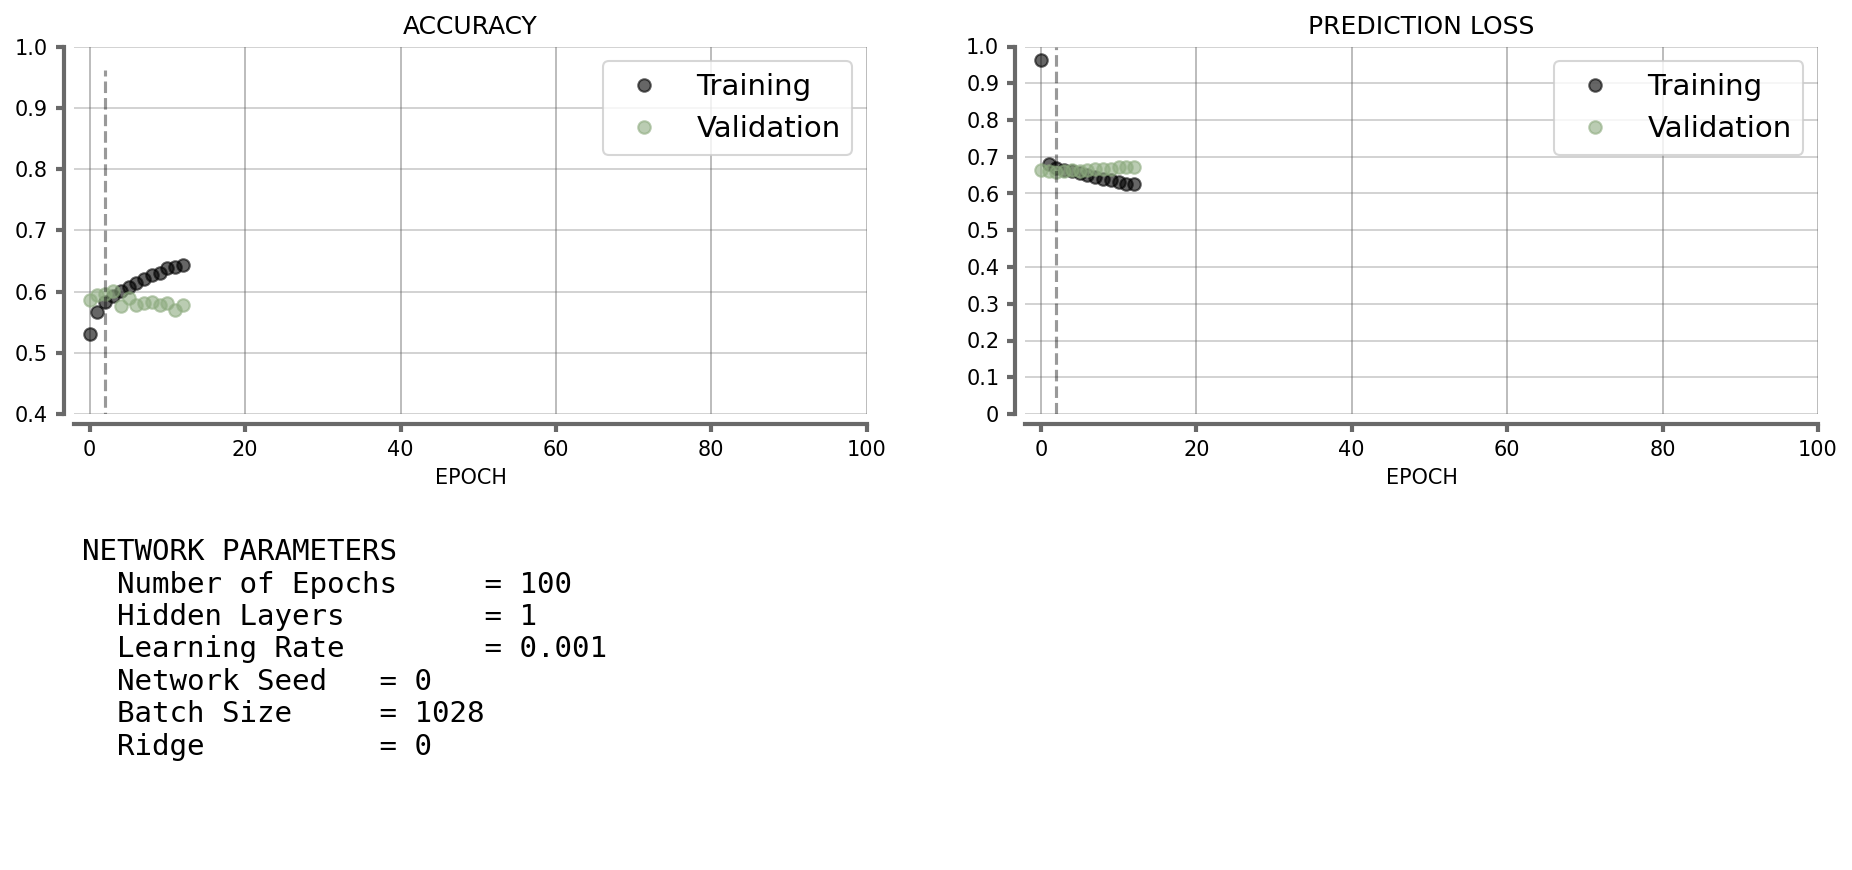

Best Trial ID: 15
Number of Layers: 1
First Layer: 128
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 1028


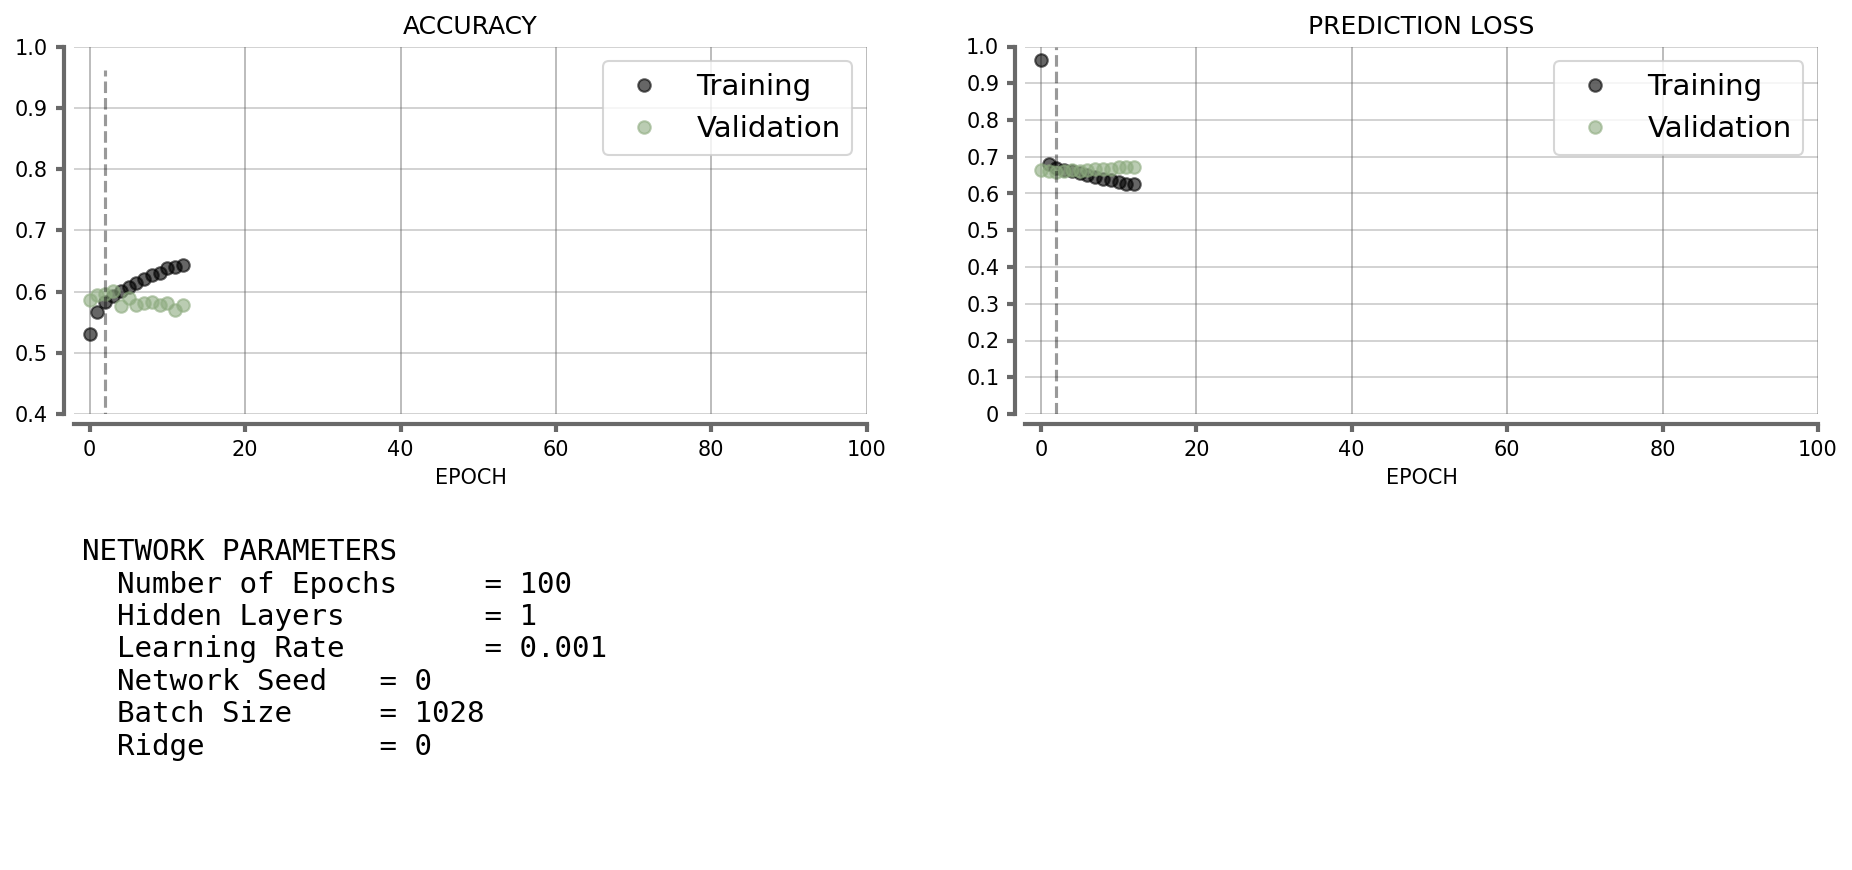

Best Trial ID: 26
Number of Layers: 2
First Layer: 256
Second Layer: 32
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 1028


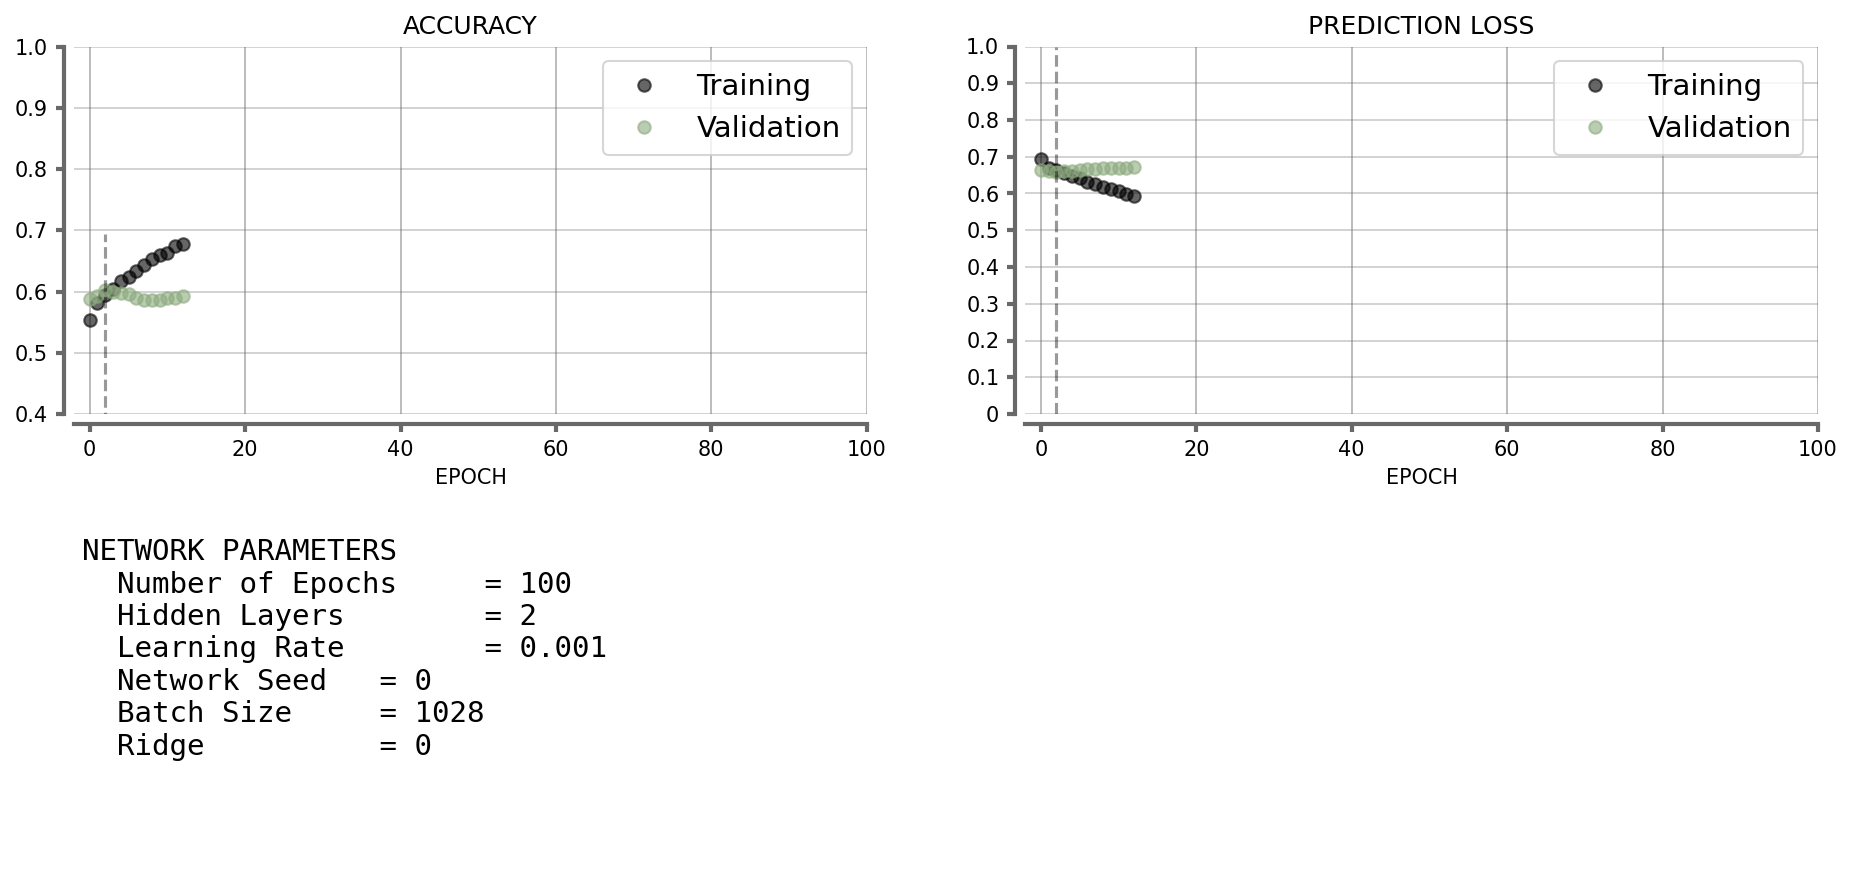

In [6]:
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
SEED = 0

for BATCH_SIZE in BATCH_SIZES:
    tuner = kt.BayesianOptimization(kt_train,
                                    objective='val_loss',
                                    max_trials=90,
                                    alpha=0.0001,
                                    beta=3, # more explorative than default=2.6
                                    directory='hp_results',
                                    project_name='hp_exp'+EXP_NAME[4]+'.BO'+str(BATCH_SIZE))
    
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    
    start_time = time.time()
    tuner.search(Xtrain,Ytrain,
                 validation_data = [Xval,Yval],
                 epochs = N_EPOCHS,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = [ES])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=5)
    
    for b_hps in range(len(best_hps)):
        trial_id = tuner.oracle.get_best_trials(num_trials=5)[b_hps].trial_id
        print(f"""Best Trial ID: {trial_id}""")
        print(f"""Number of Layers: {best_hps[b_hps].get('num_layers')}""")
        print(f"""First Layer: {best_hps[b_hps].get('units1')}""")
        if best_hps[b_hps].get('num_layers') == 2:
            print(f"""Second Layer: {best_hps[b_hps].get('units2')}""")
        print(f"""Learning Rate: {best_hps[b_hps].get('learning_rate')}""")
        print(f"""Dropout: {best_hps[b_hps].get('dropout')}""")
        print(f"""Batch Size: {BATCH_SIZE}""")
    
        # Build the model with the optimal hyperparameters and train it
        best_model = tuner.hypermodel.build(best_hps[b_hps])
        history = best_model.fit(Xtrain,Ytrain,
                                 validation_data = [Xval,Yval],
                                 epochs = N_EPOCHS,
                                 batch_size = BATCH_SIZE,
                                 shuffle = True,
                                 verbose=0,
                                 callbacks = [ES])
        
        #----- PLOT THE RESULTS -----
        plot_results(
            history,
            exp_info=(100, best_hps[b_hps].get('num_layers'), best_hps[b_hps].get('learning_rate'), BATCH_SIZE, SEED, PATIENCE, 0),
            showplot=True
        ) 
    
        annfi_name = 'ann_60Eshift_'+EXP_NAME+'_'+str(BATCH_SIZE)+'_modelnum'+str(b_hps+1)+'outof5_seed'+str(SEED)+'.h5'
        best_model.save(base_dir+'train/kerastuner_hpsearch/hp_results/hp_exp2.BO_models/'+annfi_name)

In [13]:
# Get the optimal hyperparameters
for BATCH_SIZE in BATCH_SIZES[2:3]:
    tuner = kt.BayesianOptimization(kt_train,
                            objective='val_loss',
                            max_trials=90,
                            directory='hp_results',
                            project_name='hp_exp2.BO'+str(BATCH_SIZE))
    
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    
    start_time = time.time()
    tuner.search(Xtrain,Ytrain,
                 validation_data = [Xval,Yval],
                 epochs = N_EPOCHS,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks = [ES])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

    best_hps=tuner.get_best_hyperparameters(num_trials=5)
    
    for b_hps in range(len(best_hps)):
        trial_id = tuner.oracle.get_best_trials(num_trials=5)[b_hps].trial_id
        best_trial_score = tuner.oracle.get_best_trials(num_trials=5)[b_hps].score
        print(f"""Rank: {b_hps+1}""")
        print(f"""Best Trial ID: {trial_id}""")
        print(f"""Objective Value: {best_trial_score}""")
        print(f"""Number of Layers: {best_hps[b_hps].get('num_layers')}""")
        print(f"""First Layer: {best_hps[b_hps].get('units1')}""")
        if best_hps[b_hps].get('num_layers') == 2:
            print(f"""Second Layer: {best_hps[b_hps].get('units2')}""")
        print(f"""Learning Rate: {best_hps[b_hps].get('learning_rate')}""")
        print(f"""Dropout: {best_hps[b_hps].get('dropout')}""")
        print(f"""Batch Size: {BATCH_SIZE}""")


Reloading Tuner from hp_results/hp_exp2.BO1028/tuner0.json
Elapsed time during fit = 0.00 seconds

Rank: 1
Best Trial ID: 22
Objective Value: 0.6586111783981323
Number of Layers: 1
First Layer: 256
Learning Rate: 0.0001
Dropout: 0.9
Batch Size: 1028
Rank: 2
Best Trial ID: 24
Objective Value: 0.6588342189788818
Number of Layers: 2
First Layer: 256
Second Layer: 16
Learning Rate: 0.0001
Dropout: 0.9
Batch Size: 1028
Rank: 3
Best Trial ID: 13
Objective Value: 0.6589367389678955
Number of Layers: 1
First Layer: 128
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 1028
Rank: 4
Best Trial ID: 15
Objective Value: 0.6589367389678955
Number of Layers: 1
First Layer: 128
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 1028
Rank: 5
Best Trial ID: 26
Objective Value: 0.6590209007263184
Number of Layers: 2
First Layer: 256
Second Layer: 32
Learning Rate: 0.001
Dropout: 0.9
Batch Size: 1028
